In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from implementations import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
df= pd.read_csv(DATA_TRAIN_PATH)
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


## Data Exploration 

We notice that there are some rows that have -999 as a value for some columns. This mean that the corresponding particle doesn't produce a result for the corresponding column. 
For example the collision of the particle 100002 doesn't produce a DER_mass_MMC 

In [76]:
df[df['DER_mass_MMC'].isna()].count()

Id                             38114
Prediction                     38114
DER_mass_MMC                       0
DER_mass_transverse_met_lep    38114
DER_mass_vis                   38114
DER_pt_h                       38114
DER_deltaeta_jet_jet            4429
DER_mass_jet_jet                4429
DER_prodeta_jet_jet             4429
DER_deltar_tau_lep             38114
DER_pt_tot                     38114
DER_sum_pt                     38114
DER_pt_ratio_lep_tau           38114
DER_met_phi_centrality         38114
DER_lep_eta_centrality          4429
PRI_tau_pt                     38114
PRI_tau_eta                    38114
PRI_tau_phi                    38114
PRI_lep_pt                     38114
PRI_lep_eta                    38114
PRI_lep_phi                    38114
PRI_met                        38114
PRI_met_phi                    38114
PRI_met_sumet                  38114
PRI_jet_num                    38114
PRI_jet_leading_pt             11991
PRI_jet_leading_eta            11991
P

In [3]:
# we replace all -999's by NaN
tX = np.where(tX == -999,np.nan,tX)
df.replace(-999,np.nan,inplace=True)
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


Let's count the number of particles for each property that have numeric values.

In [66]:
#df.count()[2:].plot(kind = 'barh',figsize=(6,8),title='Number of particles per properties')
df.count()[2:]

DER_mass_MMC                   211886
DER_mass_transverse_met_lep    250000
DER_mass_vis                   250000
DER_pt_h                       250000
DER_deltaeta_jet_jet            72543
DER_mass_jet_jet                72543
DER_prodeta_jet_jet             72543
DER_deltar_tau_lep             250000
DER_pt_tot                     250000
DER_sum_pt                     250000
DER_pt_ratio_lep_tau           250000
DER_met_phi_centrality         250000
DER_lep_eta_centrality          72543
PRI_tau_pt                     250000
PRI_tau_eta                    250000
PRI_tau_phi                    250000
PRI_lep_pt                     250000
PRI_lep_eta                    250000
PRI_lep_phi                    250000
PRI_met                        250000
PRI_met_phi                    250000
PRI_met_sumet                  250000
PRI_jet_num                    250000
PRI_jet_leading_pt             150087
PRI_jet_leading_eta            150087
PRI_jet_leading_phi            150087
PRI_jet_subl

We notice that some particles do not have values for some columns, this tells us that there different categories of particles.
Lets set the goal of categorizing the particles 



To analyze more we look for the properties that are shared by all particles


In [5]:
props_in_all_particles = (df.count() == len(df))
props_in_common = props_in_all_particles[props_in_all_particles == True].index.drop(['Id','Prediction'])
props_in_common

Index(['DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h',
       'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num',
       'PRI_jet_all_pt'],
      dtype='object')

We remove those columns first to get a better view of the rest of the properties 

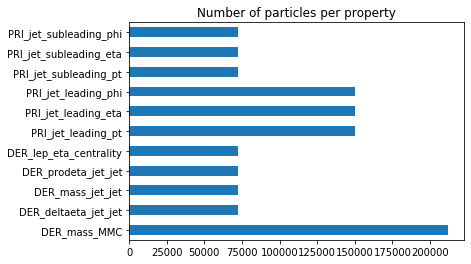

In [6]:
# reducing the dataset a to subset of properties that are not shared by all the particles
df_reduced = df.drop(columns = props_in_common)
df_reduced.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4), title='Number of particles per property')

We found the first category of particles : the ones that have all the properties in common
We name it category 1

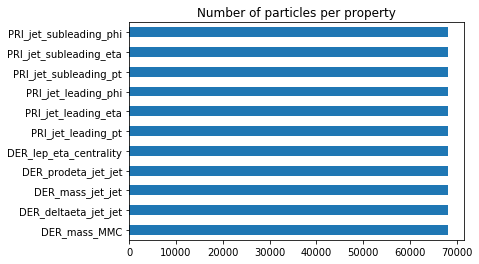

In [7]:
# We create a mask for the first category
cat1_mask = df_reduced['DER_prodeta_jet_jet'].notna() & df_reduced['DER_mass_MMC'].notna()

# We produce a new dataset without the particles of the category 1
df_wo_cat1 = df_reduced.drop(df_reduced[cat1_mask].index)

# df_wo_cat1.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property')
df_reduced[cat1_mask].count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property')



In [8]:
# We produce a new dataset containing exclusively the particles from the first category 
df_cat1 = df[cat1_mask]
print("The number of particles in category 1: {}\n".format(df_cat1.shape[0]))
df_cat1.head()

The number of particles in category 1: 68114



,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
5,100005,b,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,100006,s,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
11,100011,b,114.744,10.286,75.712,30.816,2.563,252.599,-1.401,2.888,...,2.148,290.547,3,76.773,-0.790,0.303,56.876,1.773,-2.079,165.640
23,100023,s,141.481,0.736,111.581,174.075,1.955,364.344,-0.923,1.335,...,-0.973,454.785,2,195.533,1.156,1.416,82.477,-0.798,-2.785,278.009


To continue our analysis we remove the first category of particles (ie the ones that produce a collision in which we can retrieve all the 30 properties)

In [9]:
df_without_cat1 = df[~df.isin(df_cat1).all(1)]
print("The number of particles remaining is: {}\n".format(df_without_cat1.shape[0]))
df_without_cat1.head()

The number of particles remaining is: 181886



,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
1,100001,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
7,100007,s,154.916,10.418,94.714,29.169,NaN,NaN,NaN,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,NaN,NaN,NaN,30.638


We analyse the remaining dataset to spot some other categories 

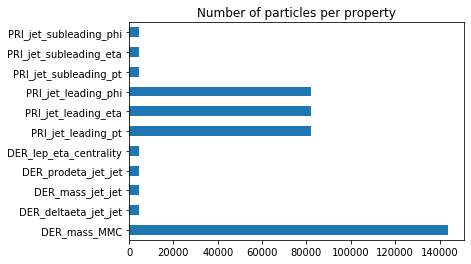

In [11]:
df_without_cat1_reduced = df_without_cat1.drop(columns = props_in_common)
df_without_cat1_reduced.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property')



We plot that small subset of particles and see if it represents a category by itself

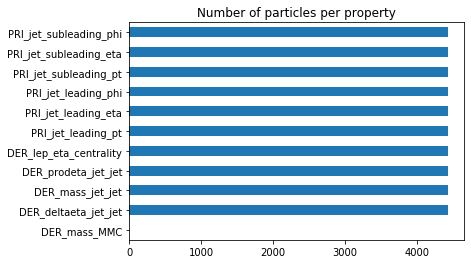

In [12]:
cat2_mask = df_without_cat1['PRI_jet_subleading_phi'].notna()
df_without_cat1_reduced[cat2_mask].count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property (cat 2)')

We found the second category of particles described above, we name it category 2

In [13]:
# We produce a new dataset containing exclusively category 2 particles
df_cat2 = df[df['Id'].isin(df_without_cat1[cat2_mask]['Id'])]
print("The number of particles of category 2 is: {}\n".format(df_cat2.shape[0]))
df_cat2.head()

The number of particles of category 2 is: 4429



,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
56,100056,b,NaN,110.686,65.448,49.395,0.482,24.020,7.901,2.893,...,-0.785,185.682,2,40.581,-3.062,2.144,30.442,-2.580,2.396,71.023
134,100134,b,NaN,95.640,73.989,54.073,0.698,89.307,0.100,2.588,...,-1.612,238.094,3,51.155,0.122,-2.564,44.163,0.820,1.655,169.164
209,100209,b,NaN,77.518,58.031,63.279,1.127,122.734,-0.229,1.256,...,1.371,351.275,2,59.283,0.266,0.218,51.029,-0.861,-2.181,110.311
441,100441,b,NaN,55.585,123.788,190.040,1.609,189.897,-0.581,3.627,...,-0.115,343.551,3,143.970,1.063,2.736,56.839,-0.547,-2.442,240.563
447,100447,b,NaN,131.295,62.487,39.784,2.209,223.241,1.194,1.556,...,1.995,138.219,2,128.401,2.658,2.107,39.805,0.449,-2.511,168.206


We remove the 4429 particles that belong to category 2 from the dataset  

In [20]:
df_without_cat1_2 = df_without_cat1[~df_without_cat1['Id'].isin(df_cat2['Id'])]

print("The number of particles remaining is: {}\n".format(df_without_cat1_2.shape[0]))
df_without_cat1_2.head()

The number of particles remaining is: 177457



,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
1,100001,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
7,100007,s,154.916,10.418,94.714,29.169,NaN,NaN,NaN,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,NaN,NaN,NaN,30.638


We continue the analysis looking for other categories 

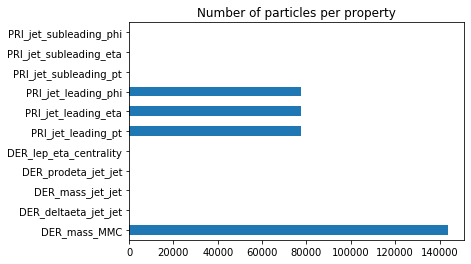

In [21]:
df_without_cat1_2_reduced = df_without_cat1_2.drop(columns = props_in_common)
df_without_cat1_2_reduced.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property')


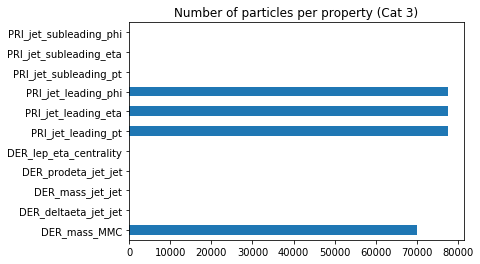

In [57]:
cat3_mask = df_without_cat1_2_reduced['PRI_jet_leading_phi'].notna() 
df_without_cat1_2_reduced[cat3_mask].count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property (Cat 3)')


In [58]:
df_cat3 = df[df['Id'].isin(df_without_cat1_2[cat3_mask]['Id'])]
print("The number of particles of category 3 is: {}\n".format(df_cat3.shape[0]))
df_cat3.head()



The number of particles of category 3 is: 77544



,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
1,100001,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
7,100007,s,154.916,10.418,94.714,29.169,NaN,NaN,NaN,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,NaN,NaN,NaN,30.638
9,100009,s,128.053,88.941,69.272,193.392,NaN,NaN,NaN,1.609,...,0.845,294.741,1,167.735,-2.767,-2.514,NaN,NaN,NaN,167.735
12,100012,b,145.297,64.234,103.565,106.999,NaN,NaN,NaN,2.183,...,-1.907,232.362,1,93.117,-0.970,1.943,NaN,NaN,NaN,93.117


In [59]:
df_without_cat1_2_3 = df_without_cat1_2[~df_without_cat1_2['Id'].isin(df_cat3['Id'])]
print("The number of particles remaining is: {}\n".format(df_without_cat1_2_3.shape[0]))
df_without_cat1_2_3.head()

The number of particles remaining is: 99913



,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
3,100003,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100004,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,100008,b,105.594,50.559,100.989,4.288,NaN,NaN,NaN,2.904,...,0.024,129.804,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
10,100010,b,NaN,86.240,79.692,27.201,NaN,NaN,NaN,2.338,...,0.688,250.178,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13,100013,b,82.488,31.663,64.128,8.232,NaN,NaN,NaN,2.823,...,1.433,163.420,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


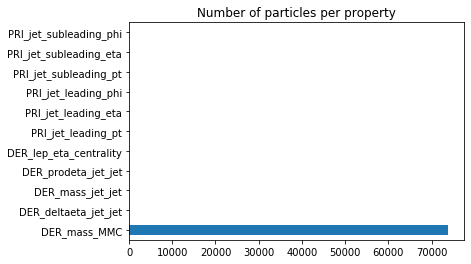

In [60]:

df_without_cat1_2_3_reduced = df_without_cat1_2_3.drop(columns = props_in_common)
df_without_cat1_2_3_reduced.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property')

The number of particles of category 4 is: 99913



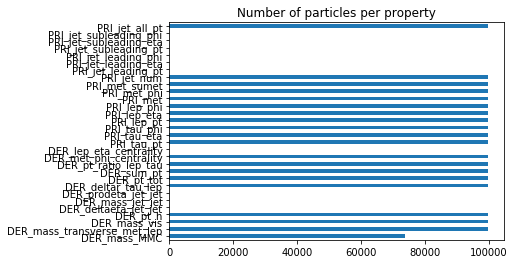

In [64]:
df_cat4 = df[df['Id'].isin(df_without_cat1_2_3_reduced['Id'])]
print("The number of particles of category 4 is: {}\n".format(df_cat4.shape[0]))
df_cat4.count().drop(['Id','Prediction']).plot(kind = 'barh',figsize = (6,4),title='Number of particles per property')


## We try with Stochastic gradient descent 

In [ ]:
initial_w = np.zeros((tX.shape[1],1))
max_iters = 50
gamma = 0.6
#weights , loss = least_squares_SGD(y,tX,initial_w,max_iters,gamma)


#print(loss)

In [ ]:
d d

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)